In [14]:
# Download and extract model
! wget http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/models/pytorch/resnet50_128_pytorch.tar.gz
! mkdir model
! tar -xvzf resnet50_128_pytorch.tar.gz -C model

In [9]:
# We will need this
# ! pip3 install gdown
# ! pip3 install shutil
# ! pip3 install tqdm
# ! sudo apt install unzip

In [16]:
# Download names
! mkdir data
! gdown https://drive.google.com/uc?id=1zRtJzbwomoRVQg5oFr621zpI0-4MnIFk
! mv names.tsv ./data/

In [15]:
# Download data
! gdown https://drive.google.com/uc?id=1jvjeTj8bJDpHvq6pJYlfxGnlLEKAHAxO
! mkdir data/test
! unzip test.zip -d data/test

In [1]:
import PIL
import torch
import glob as gb
import numpy as np
from PIL import Image
import pandas as pd

import pylab as plt
import model.resnet50_128 as model

from sklearn.model_selection import train_test_split


from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
import shutil

In [2]:
from pytorch_feature_extractor import initialize_model, image_encoding

CUDA is available!  Training on GPU ...


In [3]:
folder1 = 'data/test/folder1/'
folder2 = 'data/test/folder2/'
test_folder = 'data/test/test/'
names_file = 'data/names.tsv'

!mkdir 'data/test/folder1/' & mkdir 'data/test/folder2/'

mkdir: cannot create directory ‘data/test/folder1/’: File exists
mkdir: cannot create directory ‘data/test/folder2/’: File exists


In [28]:
# prepare datasets for testing
names = pd.read_csv(names_file, delimiter='\t', names=['class', 'image'])
names['image'] = names['image'].apply(str).apply(lambda x: test_folder+f'{x}.jpg')

sample = []
for i in range(500):
    row = names[names['class'] == i].iloc[0]
    sample.append((row['class'], row['image']))

# move 1 image from each class for prediction
for i in sample:
    shutil.copy(i[1], folder1+i[1].split('/')[-1])
    
# sample first 1000 images
for i in names['image'][:1000]:
    shutil.copy(i, folder2+i.split('/')[-1])

In [4]:
def predict(folder1:str, folder2:str) -> list:
    images1 = gb.glob(folder1 + '*.jpg')
    images2 = gb.glob(folder2 + '*.jpg')
    model_eval = initialize_model()
    folder1_face_feats = image_encoding(model_eval, images1)
    folder2_face_feats = image_encoding(model_eval, images2)
    
    S = np.dot(folder2_face_feats, folder1_face_feats.T)

    return [(images2[i], images1[images.argmax()]) for i, images in enumerate(S)]

In [5]:
def predict_once(folder1:str, image2:str) -> str:
    images1 = gb.glob(folder1 + '*.jpg')
    images2 = gb.glob(image2)
    model_eval = initialize_model()
    folder1_face_feats = image_encoding(model_eval, images1)
    folder2_face_feats = image_encoding(model_eval, images2)

    S = np.dot(folder2_face_feats, folder1_face_feats.T)

    return images1[S.argmax()]

In [6]:
# small test
# (240, 224, 3)
predictions = predict(folder1, folder2)

  0%|          | 0/32 [00:00<?, ?it/s]/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add is deprecated:
	add(Tensor input, Number alpha, Tensor other, *, Tensor out)
Consider using one of the following signatures instead:
	add(Tensor input, Tensor other, *, Number alpha, Tensor out)
100%|██████████| 63/63 [00:30<00:00,  2.08it/s]


In [14]:
# big test
predictions = predict(folder1, test_folder)

100%|██████████| 10556/10556 [1:25:35<00:00,  2.06it/s]


In [22]:
import pickle
with open('predictions.pickle', 'wb') as f:
    pickle.dump(predictions, f)

In [71]:
prediction = predict_once(folder1, 'data/test/folder2/1.jpg')
prediction

100%|██████████| 1/1 [00:00<00:00, 53.37it/s]


'data/test/folder1/0.jpg'

In [15]:
names = pd.read_csv(names_file, delimiter='\t', names=['class', 'image'])

In [16]:
class FaceImagesClassDataset(Dataset):
    """
    Images Dataset only for printing
    """
    def __init__(self, predictions, names):
        super().__init__()

        self.predictions = predictions
        self.names = names

    def load_sample(self, file):
        image = Image.open(file).convert('RGB')
        image.load()
        return image

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return image
    
    def __len__(self):
         return len(predictions)
  
    def __getitem__(self, index):
        predicted = self._prepare_sample(self.load_sample(self.predictions[index][0]))
        source = self._prepare_sample(self.load_sample(self.predictions[index][1]))
        
        source_num = predictions[index][0].split('/')[-1].split('.')[-2]
        predicted_num = predictions[index][1].split('/')[-1].split('.')[-2]
        
        source_class = names[names['image'] == int(source_num)]['class'].iloc[0]
        predicted_class = names[names['image'] == int(predicted_num)]['class'].iloc[0]
        
        return predicted, source, predicted_class, source_class
    

In [17]:
face_images_class_dataset = FaceImagesClassDataset(predictions, names)

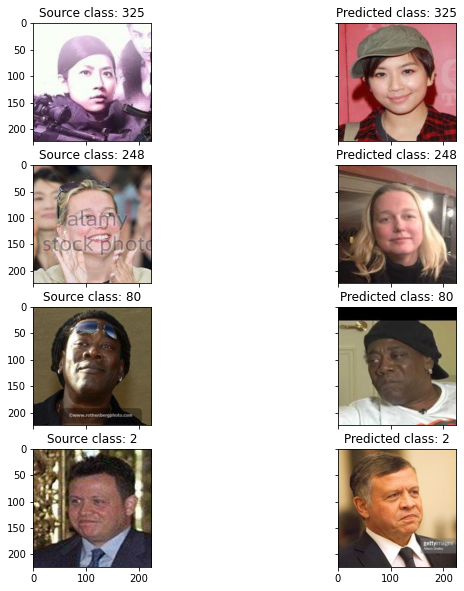

In [18]:
Ni = 4
RESCALE_SIZE = 224

fig, ax = plt.subplots(nrows=Ni, ncols=2,figsize=(10, 10), \
                        sharey=True, sharex=True)

for i in range(Ni):
    for fig_x in ax.flatten():
        random_characters = int(np.random.uniform(0, len(predictions)))
        source, predicted, source_class, predicted_class = face_images_class_dataset[random_characters]
        
        ax[i ,0].imshow(source)
        ax[i ,0].set_title('Source class: ' + str(source_class))
        ax[i ,1].imshow(predicted)
        ax[i ,1].set_title('Predicted class: ' + str(predicted_class))

In [19]:
class FaceClassDataset(Dataset):
    """
    Class Dataset only for accuracy score 
    """
    def __init__(self, predictions, names):
        super().__init__()

        self.predictions = predictions
        self.names = names

    
    def __len__(self):
         return len(predictions)
  
    def __getitem__(self, index):
        
        source_num = predictions[index][0].split('/')[-1].split('.')[-2]
        predicted_num = predictions[index][1].split('/')[-1].split('.')[-2]
        
        source_class = names[names['image'] == int(source_num)]['class'].iloc[0]
        predicted_class = names[names['image'] == int(predicted_num)]['class'].iloc[0]
        
        return predicted_class, source_class
    

In [20]:
face_class_dataset = FaceClassDataset(predictions, names)

In [21]:
def face_accuracy(face_class_dataset):
    acum = 0
    for i, face_pair in tqdm(enumerate(face_class_dataset), 
                             total = len(face_class_dataset)):
        acum += int(face_pair[0] == face_pair[1])
    return acum/len(predictions)

face_accuracy(face_class_dataset)

100%|██████████| 168896/168896 [02:43<00:00, 1035.37it/s]


0.7927778040924592